For this homework, make sure that you format your notbook nicely and cite all sources in the appropriate sections. Programmatically generate or embed any figures or graphs that you need.

Names: __Anisha Thakrar, Kavya Gajjar__

Step 1: Train your own word embeddings
--------------------------------

The dataset selected to work with is **Spooky Authors Dataset**. This dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, hence there are some odd non-sentences here and there. The dataset contains three columns:
- id: a unique identifier for each sentence
- text:, some text written by one of the authors
- author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)



Here, we are only concerned with text column of the dataset



The second dataset used is the **IMDB movie reviews dataset**, from kaggle [https://www.kaggle.com/utathya/imdb-review-dataset]. The text column used from this dataset is the **review** column.



The similarity between the datasets is that it contains the texts from various authors, but there are various differences like the spooky author's dataset will be realted to some particular writing style of authors with proper english, where as IMDB reviews dataset is more of a real time dataset, it contains, hashtags, emoticons, slangs etc. i.e. more of the social media text (how users interact on any social media platform).

In [1]:
from string import punctuation 
import nltk 
import numpy as np
import pandas as pd
import re

from gensim.models import Word2Vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Embedding


### a) Train embeddings on GIVEN dataset

In [2]:
def pre_process(data):
    norm_data = [[word.lower() for word in sent.split()] for sent in data]
    norm_data = [' '.join(tok_sent) for tok_sent in norm_data]
    norm_data = ['<s> <s> '+ sent + ' </s> </s>' for sent in norm_data]
    norm_data = [[word for word in sent.split()] for sent in norm_data]
    return norm_data

In [3]:
data = pd.read_csv('train.csv')
data = list(data['text'])
# data = data[:int(len(data)/2)]

In [4]:
data = pre_process(data)

In [5]:
EMBEDDINGS_SIZE = 200
model = Word2Vec(sentences = data,sg = 1, window=5, min_count=1, 
                 workers=4, vector_size = EMBEDDINGS_SIZE)

### b) Train embedding on YOUR dataset

In [28]:
with open('new_data.csv', encoding = 'ISO-8859-1') as f:
    new_data = f.readlines()

In [29]:
new_data = new_data[:int(len(new_data)/45)]

In [30]:
len_count = 0
for sent in new_data:
    len_count += len(sent.split())
print("Total words in dataset:",len_count)

Total words in dataset: 500095


In [31]:
new_data = pre_process(new_data)

In [32]:
model_1 = Word2Vec(sentences = new_data,sg = 1, window=5, min_count=1, workers=4, vector_size = EMBEDDINGS_SIZE)

**What text-normalization and pre-processing did you do and why?**

The preprocessing steps taken are:
- Lower case 
- Adding $<s><s>$ tags before the sentence starts and $</s></s>$ at the end of the tags.

These measures were taken since we need to compare the results with the Shannon method performed in Homework 2. To keep the pre-processing steps, we use the same pre-processing methods for both the methods. We pass the start and end tags in the dataset so that it directly starts generating sentences even if there is no previous word incoming as input to the model. We do not remove the stop words (i.e. is, the, and etc.) since it generates erroneous sentences.


Step 2: Evaluate the differences between the word embeddings
----------------------------

In [11]:
plt.rcParams["figure.figsize"] = (15,10)

In [12]:
v1 = list(model.wv.key_to_index)
v2 = list(model_1.wv.key_to_index)

In [13]:
'''
Here, we have taken the common words among both the dataset to compare the word embeddings, for computational purpose,
we have taken only first 5000 words into account for visulaization
'''
vocab = list(set(v1).intersection(v2))[:5000]

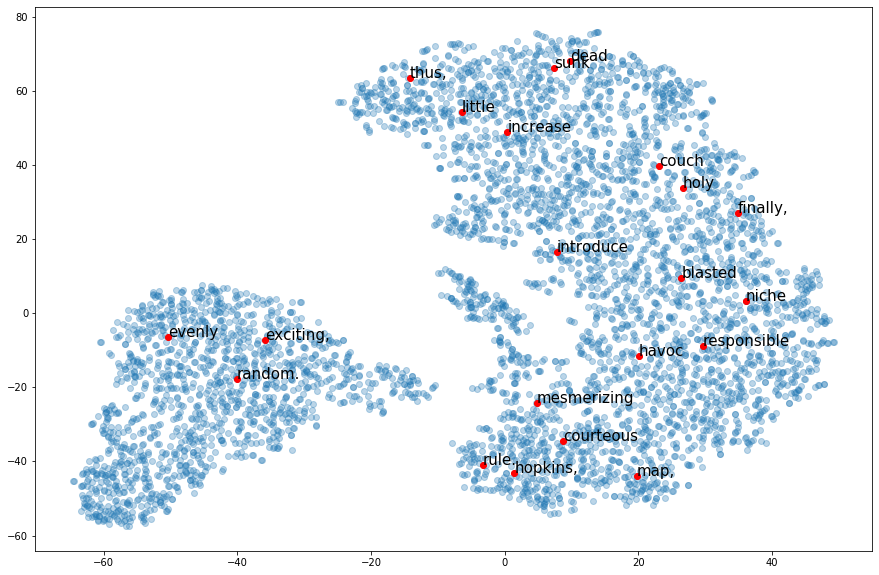

In [14]:
# vocab = list(model.wv.key_to_index)
X = model.wv[vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'], alpha = 0.3)
i = 0
for word, pos in df.iterrows():
    ax.plot(df.loc[vocab[i],'x'], df.loc[vocab[i],'y'],'-ro')
    ax.annotate(word, pos,fontsize=15)
    i += 1
    if i >20:
        break
plt.show()

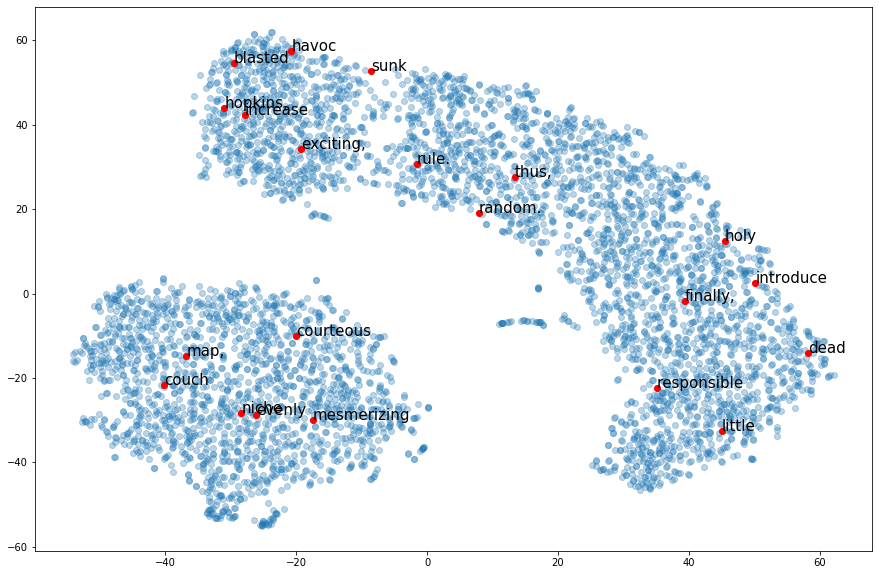

In [15]:
# vocab = list(model_1.wv.key_to_index)
X = model_1.wv[vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
    
ax.scatter(df['x'], df['y'], alpha = 0.3)
i = 0
for word, pos in df.iterrows():
    ax.plot(df.loc[vocab[i],'x'], df.loc[vocab[i],'y'],'-ro')
    ax.annotate(word, pos,fontsize=15)
    i += 1
    if i >20:
        break
plt.show()

In [16]:
def pp(model, tag, top):
    for word, val in model.wv.most_similar(tag, topn = top):
        print(word,'->', round(val,4))

In [17]:
print("Given dataset")
word = 'love'
pp(model,word, 10)
print("\n")
print("*"*20)
print("IMDB dataset")
pp(model_1,word, 10)

Given dataset
love, -> 0.9338
affection -> 0.9279
thy -> 0.9274
hope -> 0.9222
sympathy -> 0.9121
fear -> 0.9116
grief -> 0.9108
father, -> 0.9105
friend, -> 0.9099
sister, -> 0.9091


********************
IMDB dataset
friends, -> 0.9127
days, -> 0.9083
mystery -> 0.9064
tv. -> 0.9062
recall -> 0.9053
sick -> 0.9031
share -> 0.9027
prefer -> 0.9016
war -> 0.901
recognize -> 0.9004


The two graphs shown above are the word embedding plots for both Spooky and IMDB dataset. As we can see, there are two clusters in both the graphs, but the clusters in the spooky dataset are not very far, whereas the clusters in IMDB dataset are distinguishable. In the first graph, words such as **evenly, exciting and random** are present in one cluster. When we compare the same word embeddings in the IMDB dataset, the words **random and exciting** are are present in the same cluster but the word **evenly** has been separated.



Another observation is that the words **hopkins and increase** are present in the same cluster, but the distance between the two words in Spooky dataset is higher than that in the IMDB dataset.


The reason behind these differences is that the genre of the datasets used are different. This results in different occurrences of words in each dataset. Even though both the datasets have many intersecting data points, the occurrence of the same word in both the datasets is different. We can see this from the output printed above. The top 10 words similar to the word **love** are printed above. We see that there are common words in both the datasets, but the probability of the word to be similar is different in both the datasets. Another reason behind this could be that the word embedding space taken is 200 and we pass the total components as 2 in the plots. The results obtained support the reasoning.

Cite your sources:
-------------
- https://machinelearningmastery.com/what-are-word-embeddings/
- https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa?gi=da7aec4c6264

Step 3: Feedforward Neural Language Model
--------------------------

In [11]:
NGRAM = 3 
def get_X_y(data):
    tokenizer = Tokenizer(filters = '')
    tokenizer.fit_on_texts(data)
    numeric_sentences = tokenizer.texts_to_sequences(data)
    
    # creating the X, y in the form of n-grams
    X = []
    y = []
    for sent in numeric_sentences:
        i = 0
        while i+NGRAM <=(len(sent)):
            X.append(sent[i:i+NGRAM-1])
            y.append(sent[i+NGRAM-1])
            i+=1
    X = np.array(X)
    y = np.array(y)
    
    vocabulary_size = len(tokenizer.word_index)+1
    y = to_categorical(y, num_classes=vocabulary_size)
    input_length = X.shape[1]
    
    print("Vocabulary Size: ", vocabulary_size)
    print("Shape of X: ",X.shape)
    print("Shape of y: ", y.shape)
    print("Input length: ", input_length)
    
    return X,y, vocabulary_size, input_length, tokenizer

In [12]:
def get_embeddings(tokenizer, model):
    # getting embedding weights
    keys = eval(tokenizer.get_config()['word_index']).keys()
    weights = []
    weights.append(np.zeros(EMBEDDINGS_SIZE)) # because of reserving padding (i.e. index zero).
    for k in keys:
        weights.append(model.wv[k])
    weights = np.array(weights)
    
    return weights

In [13]:
def get_model(vocabulary_size, input_length, weights):
    rnn_model = Sequential()
    rnn_model.add(Embedding(input_dim=vocabulary_size, output_dim=EMBEDDINGS_SIZE, input_length = input_length,
                            weights=[weights],trainable=False))
    rnn_model.add(SimpleRNN(128))
    rnn_model.add(Dense(vocabulary_size, activation='softmax'))
    return rnn_model

In [14]:
# Chosing the next word based on probability
def get_next_word(candidates): 
    p = []
    sump = 0
    arr = []
    for i in range(len(candidates)):
        sump += candidates[i]
        arr.append(candidates[i])

    for i in range(len(candidates)):
        p.append(candidates[i]/sump)
    index = arr.index(np.random.choice(arr, 1, p = p)[0])
    return index

In [15]:
def generate_sentence(tokenizer, rnn_model):
    # Generating 50 sentences
    for sent in range(50):
        print('Sentence No:',sent+1)
        word = ['']
        max_len = 20
        i = 0
        start = [['<s>','<s>']]
        for w in start[0]:
            print(w, end = ' ')
        while (word[0] != '</s>') and (i < max_len):
            start_seq = tokenizer.texts_to_sequences(start)
            pred = rnn_model.predict(start_seq)
            p = [get_next_word(list(pred[0]))]
            word = tokenizer.sequences_to_texts([p])
            start[0] = start[0][1:]+ word
            print(word[0],end=" ")
            i += 1
        if word[0]!= '</s>':
            print('</s> </s>')
        else:
            print('</s>')
    pass

### Given dataset

In [33]:
X,y, vocabulary_size, input_length, tokenizer = get_X_y(data)

Vocabulary Size:  44898
Shape of X:  (562514, 2)
Shape of y:  (562514, 44898)
Input length:  2


In [35]:
weights = get_embeddings(tokenizer, model)

In [36]:
rnn_model = get_model( vocabulary_size, input_length, weights)
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2, 200)            8979600   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               42112     
                                                                 
 dense_1 (Dense)             (None, 44898)             5791842   
                                                                 
Total params: 14,813,554
Trainable params: 5,833,954
Non-trainable params: 8,979,600
_________________________________________________________________


In [19]:
rnn_model.load_weights('spooky.h5')

In [20]:
%%time
import keras
rnn_model.compile(
    loss= 'categorical_crossentropy',
    optimizer="adam",
    metrics=["accuracy"], ) 
rnn_model.fit(X,y, batch_size = 1024,epochs=3)

Epoch 1/3
550/550 [==============================] - 477s 865ms/step - loss: 5.3391 - accuracy: 0.1983
Epoch 2/3
550/550 [==============================] - 445s 809ms/step - loss: 5.1867 - accuracy: 0.1993
Epoch 3/3
550/550 [==============================] - 450s 818ms/step - loss: 5.0804 - accuracy: 0.1997
CPU times: user 37min 58s, sys: 7min 36s, total: 45min 34s
Wall time: 23min 36s


In [21]:
rnn_model.save_weights("spooky.h5")

In [22]:
generate_sentence(tokenizer, rnn_model)

Sentence No: 1
<s> <s> a diddler of great fire of government beyond want, i knew himself copper gained for her lives in , trees </s> </s>
Sentence No: 2
<s> <s> "and these subjects. </s> </s>
Sentence No: 3
<s> <s> but often she continued arranged he had also come with yet the hour of satiated a certain strong deaths of </s> </s>
Sentence No: 4
<s> <s> there are vain, and fluttered had been thrown away to the ancient earth. </s> </s>
Sentence No: 5
<s> <s> exhibition proved, a voice child during another. </s> </s>
Sentence No: 6
<s> <s> in autumn stood beside her own semblance for the rudimental explosion songs dear. </s> </s>
Sentence No: 7
<s> <s> the good pity, and serpent too, what i was at last where the little watches "the ha "i elwood should </s> </s>
Sentence No: 8
<s> <s> the idea of the itinerant of his ancestor luminosity; from harris, and, dropping at the door. </s> </s>
Sentence No: 9
<s> <s> if they were able, alive with a bottom which led to the southeast, uneven that co

## For own dataset

In [37]:
X,y, vocabulary_size, input_length, tokenizer = get_X_y(new_data)

Vocabulary Size:  51218
Shape of X:  (504539, 2)
Shape of y:  (504539, 51218)
Input length:  2


In [38]:
weights = get_embeddings(tokenizer, model_1)

In [39]:
rnn_model = get_model( vocabulary_size, input_length, weights)
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2, 200)            10243600  
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               42112     
                                                                 
 dense_2 (Dense)             (None, 51218)             6607122   
                                                                 
Total params: 16,892,834
Trainable params: 6,649,234
Non-trainable params: 10,243,600
_________________________________________________________________


In [40]:
rnn_model.load_weights('imdb.h5')

In [41]:
%%time
rnn_model.compile(
    loss= 'categorical_crossentropy',
    optimizer="adam",
    metrics=["accuracy"], ) 
rnn_model.fit(X,y, batch_size = 1024,epochs=3)

Epoch 1/3
493/493 [==============================] - 580s 1s/step - loss: 6.4111 - accuracy: 0.1311
Epoch 2/3
493/493 [==============================] - 598s 1s/step - loss: 6.1375 - accuracy: 0.1357
Epoch 3/3
493/493 [==============================] - 613s 1s/step - loss: 5.9457 - accuracy: 0.1388
CPU times: user 40min 47s, sys: 16min 33s, total: 57min 20s
Wall time: 30min 36s


In [42]:
rnn_model.save_weights('imdb.h5')

In [43]:
generate_sentence(tokenizer, rnn_model)

Sentence No: 1
<s> <s> "the lpwa who then the action genre and the 'squint'.<br </s> </s>
Sentence No: 2
<s> <s> upon. want to see that film in dutch it's a better tropical of effect, and writing central isn't how the </s> </s>
Sentence No: 3
<s> <s> """go character shoved has one comic discerning even if you have seen the first time me." and mentally sheriff died </s> </s>
Sentence No: 4
<s> <s> "this film, i really wish to say that why has any book here - a lot of dull. by shallow </s> </s>
Sentence No: 5
<s> <s> "dorothy wire-work. has as some people will help after again?) padding aspects i could familiar better except just need why </s> </s>
Sentence No: 6
<s> <s> "seriously, scott with some room nanny, like an early deadening of the surrounding leading & common reviewer, and it's not </s> </s>
Sentence No: 7
<s> <s> "this was them named roberts, gets the very vomiting enlightened bad of the dramatic writing.<br /><br ""turn watchable chainsaw performance </s> </s>
Sentence No: 8


**Do your neural language models produce n-grams that were not observed during training?**

The neural language model produces different n-grams that are not observed during the training. This is because the RNN is dependent on the previous word in the sentence. The probability distribution for the next word prediction is also different for the same previous. For sentence generation, the text is passed through the softmax functions which gives different probability distribution. The word selected is not always present in the sentences that have been trained earlier. Hence, the generated sentence has high chances of not being present in the training data.

**Comparison with Shannon’s method with the statistical n-gram language models**

The sentence generation by RNN is better than that from the Shannon method. This is because in RNN, the context of the previous word is kept into consideration while selecting the next word along with the probability distribution of the previous n-1 words. On the other and, Shannon method selects the next word on the basis of the probability distribution of n-1 previous words. Using RNN to generate sentences is a better option even if the previous words are the same, because the probability distribution for each word will be different whereas that of Shannon method will always be same.

Sources Cited
----------------------------
- https://www.tensorflow.org/text/tutorials/text_generation
- https://gilberttanner.com/blog/generating-text-using-a-recurrent-neuralnetwork
- https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/